# Dogs breeds

https://youtu.be/JNxcznsrRb8?t=1h31m8s

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
PATH = "data/dogbreed/"
sz = 224
arch = resnext101_64
bs = 64

In [4]:
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv))) - 1 # header is not counted (-1)
val_idxs = get_cv_idxs(n) # random 20% data for validation set

## Initial model

In [5]:
def get_data(sz, bs): # sz: image size, bs: batch size
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test',
                                       val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)
    
    # http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/13
    # http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/37
    return data if sz > 300 else data.resize(340, 'tmp') # Reading the jpgs and resizing is slow for big images, so resizing them all to 340 first saves time


### Precompute

In [6]:
data = get_data(sz, bs)

In [7]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [8]:
learn.model = nn.DataParallel(learn.model, device_ids=[0, 1])

AttributeError: can't set attribute

In [9]:
learn.model = torch.nn.DataParallel(learn.model, device_ids=[0, 1])

AttributeError: can't set attribute

In [10]:
learn.fit(1e-2, 5)

epoch      trn_loss   val_loss   accuracy                    
    0      0.988501   0.398847   0.901663  
    1      0.445553   0.301536   0.914384                     
    2      0.320016   0.275503   0.915362                     
    3      0.23846    0.260787   0.923679                     
    4      0.199005   0.24884    0.925147                     



[0.24883962024564613, 0.92514677022068]

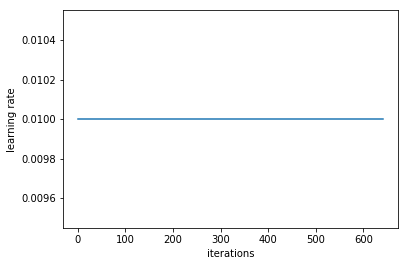

In [11]:
learn.sched.plot_lr()

### Augment

In [12]:
from sklearn import metrics

In [13]:
data = get_data(sz, bs)

In [14]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

In [15]:
learn.fit(1e-2, 2)

epoch      trn_loss   val_loss   accuracy                    
    0      1.262694   0.46178    0.901663  
    1      0.58865    0.318633   0.918297                     



[0.3186334701083644, 0.9182974556187594]

In [16]:
learn.precompute = False

In [ ]:
learn.fit(1e-2, 5, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.483683   0.294616   0.920254  
    1      0.438041   0.280608   0.918787                    
    2      0.391137   0.265534   0.926125                    
    3      0.368365   0.261036   0.921233                    
 84%|████████▎ | 107/128 [07:30<01:23,  3.97s/it, loss=0.353]

In [20]:
model = torch.nn.DataParallel(learn.model, device_ids=[0, 1])

AttributeError: can't set attribute

In [37]:
learn.save('224_pre')

In [38]:
learn.load('224_pre')

## Increase size

In [39]:
# Starting training on small images for a few epochs, then switching to bigger images, and continuing training is an amazingly effective way to avoid overfitting.

# http://forums.fast.ai/t/planet-classification-challenge/7824/96
# set_data doesn’t change the model at all. It just gives it new data to train with.
learn.set_data(get_data(299, bs)) 
learn.freeze()

#Source:   
#    def set_data(self, data, precompute=False):
#        super().set_data(data)
#        if precompute:
#            self.unfreeze()
#            self.save_fc1()
#            self.freeze()
#            self.precompute = True
#        else:
#            self.freeze()
#File:      ~/fastai/courses/dl1/fastai/conv_learner.py

In [40]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 299, 299]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('trainable', False),
                           ('nb_params', tensor(9408))])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('trainable', False),
                           ('nb_params', tensor(128))])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 75, 75]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape

In [41]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                      
    0      0.41795    0.237333   0.924168  
    1      0.352113   0.238728   0.926125                      
    2      0.355436   0.2533     0.922211                      



[0.25330016431043295, 0.9222113502935421]

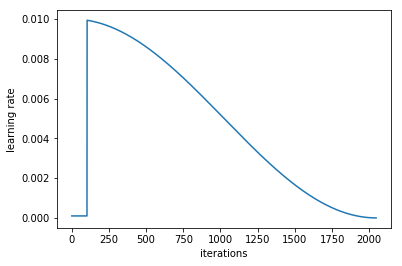

In [65]:
learn.sched.plot_lr()

Validation loss is much lower than training loss. This is a sign of underfitting. Cycle_len=1 may be too short. Let's set cycle_mult=2 to find better parameter.

In [42]:
# When you are under fitting, it means cycle_len=1 is too short (learning rate is getting reset before it had the chance to zoom in properly).
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2) # 1+2+4 = 7 epochs

epoch      trn_loss   val_loss   accuracy                      
    0      0.3541     0.251065   0.918787  
    1      0.366038   0.258714   0.921233                      
    2      0.269755   0.24318    0.926614                      
    3      0.36185    0.270407   0.919765                      
    4      0.317933   0.246284   0.924658                      
    5      0.248857   0.237878   0.922211                      
    6      0.261651   0.24449    0.926125                      



[0.24448958091773165, 0.9261252446183953]

Training loss and validation loss are getting closer and smaller. We are on right track.

In [43]:
log_preds, y = learn.TTA() # (5, 2044, 120), (2044,)
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.928082191780822, 0.2181560029462035)

In [44]:
len(data.val_ds.y), data.val_ds.y[:5]

(2044, array([19, 15,  7, 99, 73]))

In [45]:
learn.save('299_pre')

In [46]:
learn.load('299_pre')

In [47]:
learn.fit(1e-2, 1, cycle_len=2) # 1+1 = 2 epochs

epoch      trn_loss   val_loss   accuracy                      
    0      0.294714   0.26432    0.925147  
    1      0.215342   0.243844   0.92955                       



[0.243844070779834, 0.9295499021526419]

In [48]:
learn.save('299_pre')

In [49]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.9339530332681018, 0.2187812394188256)

This dataset is so similar to ImageNet dataset. Training convolution layers doesn't help much. We are not going to unfreeze.

## Create submission

https://youtu.be/9C06ZPF8Uuc?t=1905

In [50]:
data.classes

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'black-and-tan_coonhound',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'border_collie',
 'border_terrier',
 'borzoi',
 'boston_bull',
 'bouvier_des_flandres',
 'boxer',
 'brabancon_griffon',
 'briard',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chesapeake_bay_retriever',
 'chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly-coated_retriever',
 'dandie_dinmont',
 'dhole',
 'dingo',
 'doberman',
 'english_foxhound',
 'english_setter',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'flat-coated_retriever',
 'french_bulldog',
 'german_shepherd',
 'german_short-haired_pointer',
 'giant_schnauzer',
 'golden_retriever',
 'gordon_setter',
 'great_dane',
 'great_pyrenees',
 'greater_swiss_mountain_dog',
 'groenendael',


In [51]:
data.test_ds.fnames

['test/d08aa4f13841c6f503b7a6a93104ff55.jpg',
 'test/cd0a8261be06236f76518a976d38c071.jpg',
 'test/7bf38cfc0a1dd42f62f45bc6978a0c8f.jpg',
 'test/a47862ab7dbc2226a0b93d566e01245d.jpg',
 'test/591a8fc5d7a9c5a6b25101c4f6a8cbcc.jpg',
 'test/f2b7d11ea6ccf65f214cac2abee8d1a1.jpg',
 'test/780138a84209e9f448bcec64a61e3e2e.jpg',
 'test/f57f8ce3fe1d928828e37a9bd78574d9.jpg',
 'test/f8d6584fa27b951bfef528ccf5834ec7.jpg',
 'test/c36ca7ca7d49703b30d04a41064b28f8.jpg',
 'test/e79030be9c9769f3604474aea16039bd.jpg',
 'test/178e636aafb169a385215a6daf1cbf5a.jpg',
 'test/225c26ac46d7f551d779d654ccb0bddc.jpg',
 'test/8b842f121c77fc2ca1eaac41fea241cf.jpg',
 'test/6a2dc8880da477f5b3ea0a00c63faa3c.jpg',
 'test/9c84890aaf6d057d4e9ed04eebe025f5.jpg',
 'test/7a188995129759b9ffaa05b5599056aa.jpg',
 'test/fc7f0d4ae4e277804c859955866c61f4.jpg',
 'test/8b0bb138f43faaeafd1c52ed79ce0067.jpg',
 'test/56eef5133aeac23ce93a07e43be7d22f.jpg',
 'test/01cb83d33e905e825df41b88dd4ef277.jpg',
 'test/f7f585083fb639c3bfced127e2c

In [52]:
log_preds, y = learn.TTA(is_test=True) # use test dataset rather than validation dataset
probs = np.mean(np.exp(log_preds),0)
#accuracy_np(probs, y), metrcs.log_loss(y, probs) # This does not make sense since test dataset has no labels

In [53]:
probs.shape # (n_images, n_classes)

(10357, 120)

In [54]:
df = pd.DataFrame(probs)
df.columns = data.classes

In [55]:
df.insert(0, 'id', [o[5:-4] for o in data.test_ds.fnames])

In [56]:
df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,d08aa4f13841c6f503b7a6a93104ff55,3.934770e-08,7.564871e-08,1.583244e-06,7.849025e-07,7.124346e-08,8.706577e-09,1.070406e-08,1.924768e-08,4.315397e-08,...,3.856086e-09,4.649810e-09,7.747506e-08,1.147283e-08,4.764209e-07,8.764062e-07,2.643643e-08,1.125387e-06,4.396826e-08,2.544428e-09
1,cd0a8261be06236f76518a976d38c071,1.066774e-08,6.757971e-09,3.265323e-08,1.334350e-05,9.145616e-09,1.600296e-09,9.974936e-01,2.987869e-05,6.262483e-10,...,4.170507e-09,1.194652e-06,1.450957e-06,8.297370e-08,2.566095e-09,1.688070e-07,4.520248e-08,5.276888e-09,2.819403e-07,5.428075e-07
2,7bf38cfc0a1dd42f62f45bc6978a0c8f,2.070170e-09,3.459347e-08,1.168712e-09,1.180407e-08,1.112684e-10,2.279423e-10,4.766567e-10,1.092129e-11,6.434654e-11,...,1.779666e-10,2.199521e-10,3.320014e-11,1.640749e-10,6.896640e-10,5.421121e-11,6.463034e-11,1.769569e-10,3.001991e-06,4.090783e-11
3,a47862ab7dbc2226a0b93d566e01245d,9.773124e-07,1.610764e-07,1.894344e-07,5.429814e-08,8.303564e-07,1.113365e-06,3.585559e-06,1.851004e-04,9.832483e-08,...,1.484557e-07,2.419247e-06,3.767458e-07,2.445553e-06,8.322856e-07,1.320106e-07,1.847863e-07,6.234301e-09,2.045518e-08,6.695990e-08
4,591a8fc5d7a9c5a6b25101c4f6a8cbcc,9.864432e-09,3.051108e-12,1.013300e-10,2.263308e-12,2.701234e-10,2.519160e-09,3.238358e-09,5.070011e-10,1.437073e-11,...,1.781458e-11,1.849373e-10,7.259382e-11,4.346614e-11,5.604504e-10,1.314044e-11,1.003935e-10,1.471030e-11,1.961420e-12,3.199817e-11


In [57]:
SUBM = f'{PATH}/subm/'
os.makedirs(SUBM, exist_ok=True)
df.to_csv(f'{SUBM}subm.gz', compression='gzip', index=False)

In [58]:
FileLink(f'{SUBM}subm.gz')

/home/zhossain/myProjects/deeplearning/fastai/courses/dl1/data/dogbreed/subm/subm.gz

## Individual prediction

In [74]:
fn = data.val_ds.fnames[3]
fn

'train/004396df1acd0f1247b740ca2b14616e.jpg'

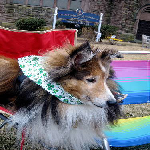

In [75]:
Image.open(PATH + fn).resize((150, 150))

In [76]:
# Method 1.
trn_tfms, val_tfms = tfms_from_model(arch, sz)
ds = FilesIndexArrayDataset([fn], np.array([0]), val_tfms, PATH)
dl = DataLoader(ds)
preds = learn.predict_dl(dl)
np.argmax(preds)

99

In [77]:
learn.data.classes[np.argmax(preds)]

'shetland_sheepdog'

In [63]:
# Method 2.
trn_tfms, val_tfms = tfms_from_model(arch, sz)
im = val_tfms(open_image(PATH + fn)) # open_image() returns numpy.ndarray
preds = learn.predict_array(im[None])
np.argmax(preds)

19